# 06, Multi-Point Regression

Here we deal with a single leaf image and we have to predict wether the leaf is healthy, has multiple diseases, has rust, has scab.   
So one input image and 4 columns to predict.  
In the [evaluation](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview/evaluation) we have `For each image_id in the test set, you must predict a probability for each target variable. ` so we'll set it up as a regression problem.   
The [data](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data) is available here.

In [ ]:
!pip install fastai -q --upgrade

In [ ]:
from fastai.vision.all import *
import pandas as pd

Download and unzip your data to a folder called `plant`

In [ ]:
path= 'plant/'

Let us see what is there in train.csv

In [ ]:
train = pd.read_csv(path+'train.csv')

In [ ]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


We need to create a tuple is `(x,y)` for our model to train. So we'll create like this `(image_id,	[healthy	multiple_diseases	rust	scab])`Let's create a new column `combined` which is a list of the dependent variables

In [ ]:
train['combined'] = train[['healthy','multiple_diseases','rust','scab']].values.tolist()
train.head()

,image_id,healthy,multiple_diseases,rust,scab,combined
0,Train_0,0,0,0,1,"[0, 0, 0, 1]"
1,Train_1,0,1,0,0,"[0, 1, 0, 0]"
2,Train_2,1,0,0,0,"[1, 0, 0, 0]"
3,Train_3,0,0,1,0,"[0, 0, 1, 0]"
4,Train_4,1,0,0,0,"[1, 0, 0, 0]"


For `show_batch` to work we need to add the ability for a list to have `show_title`

In [ ]:
class TitledList(list, ShowTitle):
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(self, ctx=ctx, **merge(self._show_args, kwargs))

In [ ]:
class ToListTensor(Transform):
    "Transform to int tensor"
    # order = 10 #Need to run after PIL transforms on the GPU
    _show_args = {'label': 'text'}
    def __init__(self, split_idx=None,):
        super().__init__(split_idx=split_idx)

    def encodes(self, o): return o
    # def decodes(self, o): return TitledNumberShort(o)
    def decodes(self, o): return TitledList(o)

Independent variable is the image we'll use a ImageBlock.   
Dependent varaible we'll use a RegressionBlock, here we need to set `c_out`.  
And we add `ToListTensor` to the `get_y`

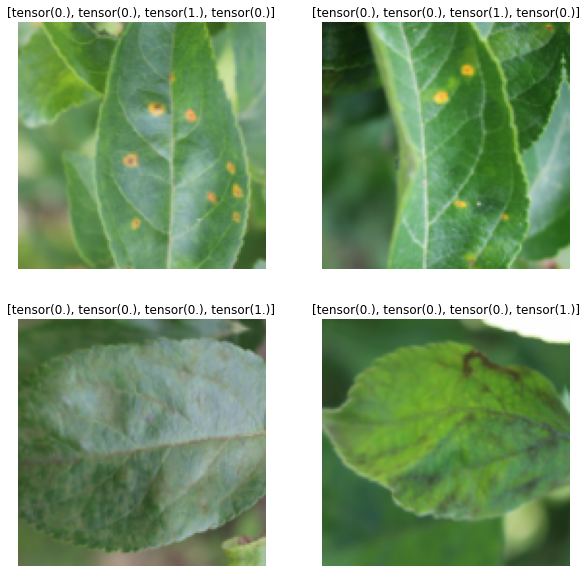

In [ ]:
blocks = [ImageBlock, RegressionBlock(c_out=4)]

item_tfms = [Resize(150)];# size should be bigger
batch_tfms = [*aug_transforms(flip_vert=True,size=(128)), Normalize.from_stats(*imagenet_stats)]
splitter = RandomSplitter()
plant = DataBlock(blocks =blocks,
                  get_x = ColReader('image_id', pref=f'gdrive/My Drive/kaggle/plant/images/',suff='.jpg'),
                  get_y = Pipeline([ColReader('combined'),ToListTensor]),
                  splitter =splitter,
                  item_tfms=item_tfms,
                  batch_tfms = batch_tfms,
                  n_inp = 1
                  )
dls = plant.dataloaders(train)
dls.show_batch(nrows=2,ncols=2,figsize=(10,10))

In [ ]:
plant.summary(train)

key things to notice:  
[0, 0, 0, 1] becomes tensor([0., 0., 0., 1.])

In [ ]:
dls.c = 4

In [ ]:
model = resnet18

Choose an appropriate Loss function and accuracy for a regression problem

In [ ]:
learn = cnn_learner(dls, model, metrics=[MSELossFlat()], loss_func=L1LossFlat(),y_range=(0,1),)

In [ ]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,None,time
0,0.411631,0.308295,0.213967,02:43


epoch,train_loss,valid_loss,None,time
0,0.272085,0.216648,0.156882,03:25
1,0.230767,0.187466,0.134689,03:26


Choose an appropriate Loss function and accuracy for a regression problem

In [ ]:
learn = cnn_learner(dls, model, metrics=[MSELossFlat()], loss_func=MSELossFlat(),y_range=(0,1),)

In [ ]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,None,time
0,0.289035,0.198776,0.198776,02:57


epoch,train_loss,valid_loss,None,time
0,0.195093,0.142944,0.142944,03:30
1,0.161028,0.110470,0.110470,03:26


### Inference

In [ ]:
test_img = pd.read_csv(path+'test.csv')

In [ ]:
dl = learn.dls.test_dl(test_img)
probs,_ = learn.get_preds(dl=dl)

In [ ]:
p1 = pd.DataFrame(probs,columns=[['healthy','multiple_diseases','rust','scab']])
p1['image_id'] = test_img.image_id
cols = ['image_id','healthy','multiple_diseases','rust','scab']
p1[cols].head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.025949,0.068522,0.773150,0.164443
1,Test_1,0.008960,0.799088,1.000000,0.000218
2,Test_2,0.004088,0.243557,0.002493,0.999968
3,Test_3,0.999977,0.052390,0.000904,0.000888
4,Test_4,0.003274,0.480604,1.000000,0.000044
